In [1]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt
import random
import numpy as np

# Constants
SEED = 42
DATASET_FRACTION = 50
MODEL_NAME = "Qwen/Qwen3-14B"
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if str(device) == 'cpu':
    raise RuntimeError('Device in use is not cuda')

Using device: cuda


In [2]:
# Preprocessing
print("Loading datasets...")
data = []
tasks = {
    "squad_v2": load_dataset("squad_v2", split=f"validation[:{DATASET_FRACTION}]").shuffle(seed=SEED),
    "ag_news": load_dataset("ag_news", split=f"test[:{DATASET_FRACTION}]").shuffle(seed=SEED),
    "snli": load_dataset("snli", split=f"validation[:{DATASET_FRACTION}]").shuffle(seed=SEED),
    "trec": load_dataset("trec", split=f"test[:{DATASET_FRACTION}]", trust_remote_code=True).shuffle(seed=SEED),
    "wmt14": load_dataset("wmt14", "de-en", split=f"test[:{DATASET_FRACTION}]").shuffle(seed=SEED)
}

unified_data = {}

for name, dataset in tasks.items():
    dataset_entries = []
    for example in dataset:
        if name == "squad_v2" and example["answers"]["text"]:
            dataset_entries.append({"question": example["question"], "context": example["context"], "answer": example["answers"]["text"][0]})
        elif name == "ag_news":
            dataset_entries.append({"question": example["text"], "context": example["text"], "answer": str(example["label"])})
        elif name == "snli" and example["label"] != -1:
            dataset_entries.append({"question": example["premise"], "context": example["hypothesis"], "answer": str(example["label"])})
        elif name == "trec":
            dataset_entries.append({"question": example["text"], "context": example["text"], "answer": str(example["coarse_label"])})
        elif name == "wmt14":
            dataset_entries.append({"question": example["translation"]["de"], "context": example["translation"]["de"], "answer": example["translation"]["en"]})
    unified_data[name] = dataset_entries

Loading datasets...


In [3]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, device_map="auto", torch_dtype=torch.float16, trust_remote_code=True)
model.eval()

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 5120)
    (layers): ModuleList(
      (0-39): 40 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (v_proj): Linear(in_features=5120, out_features=1024, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (q_norm): Qwen3RMSNorm((128,), eps=1e-06)
          (k_norm): Qwen3RMSNorm((128,), eps=1e-06)
        )
        (mlp): Qwen3MLP(
          (gate_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (up_proj): Linear(in_features=5120, out_features=17408, bias=False)
          (down_proj): Linear(in_features=17408, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen3RMSNorm((5120,), eps=1e-06)
        (post_attention_layernorm): 

In [4]:
# # Evaluation
# def evaluate(dataset_name, examples):
#     predictions = []
#     references = []
#     print(f"Evaluating {dataset_name}...")
#     for ex in examples:
#         prompt = f"Q: {ex['question']}\nA:"
#         pred = generate_answer(prompt)
#         predictions.append(pred.strip())
#         references.append(ex["answer"].strip())

#     print("Computing metrics...")
#     rouge = Rouge()
#     rouge_scores = rouge.get_scores(predictions, references, avg=True)
#     P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)

#     bleu = [sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1) for ref, pred in zip(references, predictions)]

#     metrics = {
#         "BLEU": np.mean(bleu),
#         "BERTScore_F1": F1.mean().item(),
#         "ROUGE-L": rouge_scores["rouge-l"]["f"]
#     }
#     return metrics

In [5]:
import numpy as np
from rouge import Rouge
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer
import faiss
import networkx as nx

# Инициализация модели для retrieval
retriever_model = SentenceTransformer("all-MiniLM-L6-v2")
faiss_index = None
retrieval_docs = None

# --- FAISS Retrieval для RAG ---
def build_faiss_index(contexts):
    global faiss_index, retrieval_docs
    retrieval_docs = contexts
    doc_embeddings = retriever_model.encode(contexts, show_progress_bar=True, convert_to_numpy=True)
    faiss_index = faiss.IndexFlatL2(doc_embeddings.shape[1])
    faiss_index.add(doc_embeddings)

def retrieve_context(question, top_k=1):
    question_embedding = retriever_model.encode([question], convert_to_numpy=True)
    _, indices = faiss_index.search(np.array(question_embedding), top_k)
    return " ".join([retrieval_docs[i] for i in indices[0]])

# --- Evaluation ---
def evaluate(dataset_name, examples, use_rag=False):
    predictions = []
    references = []
    mode = "RAG" if use_rag else "NoPrep"
    print(f"Evaluating {dataset_name} ({mode})...")

    if use_rag:
        build_faiss_index([ex["context"] for ex in examples])

    for ex in examples:
        if use_rag:
            retrieved = retrieve_context(ex["question"])
            prompt = f"Context: {retrieved}\nQ: {ex['question']}\nA:"
        else:
            prompt = f"Q: {ex['question']}\nA:"

        pred = generate_answer(prompt)
        predictions.append(pred.strip())
        references.append(ex["answer"].strip())

    print("Computing metrics...")
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, references, avg=True)
    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    bleu = [sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1) for ref, pred in zip(references, predictions)]

    metrics = {
        "BLEU": np.mean(bleu),
        "BERTScore_F1": F1.mean().item(),
        "ROUGE-L": rouge_scores["rouge-l"]["f"]
    }
    return metrics

In [9]:
import numpy as np
from nltk import ngrams
from collections import Counter
from rouge import Rouge
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def build_ngram_model(contexts, n=2):
    ngram_counts = Counter()
    for context in contexts:
        tokens = context.lower().split()
        ngram_counts.update(ngrams(tokens, n))
    total_ngrams = sum(ngram_counts.values())
    ngram_probs = {ng: count / total_ngrams for ng, count in ngram_counts.items()}
    return ngram_probs

def extract_key_phrases(context, ngram_probs, top_k=5):
    tokens = context.lower().split()
    context_ngrams = list(ngrams(tokens, 2))
    scored_phrases = [(ng, ngram_probs.get(ng, 0)) for ng in context_ngrams]
    scored_phrases.sort(key=lambda x: x[1], reverse=True)
    top_phrases = [' '.join(ng) for ng, _ in scored_phrases[:top_k]]
    return top_phrases

def evaluate(dataset_name, examples, use_plm=False):
    predictions = []
    references = []
    print(f"Evaluating {dataset_name} ({'PLM' if use_plm else 'NoPrep'})...")

    if use_plm:
        contexts = [ex["context"] for ex in examples]
        ngram_probs = build_ngram_model(contexts, n=2)

    for ex in examples:
        if use_plm:
            key_phrases = extract_key_phrases(ex["context"], ngram_probs)
            prompt = f"Key Phrases: {', '.join(key_phrases)}\nQ: {ex['question']}\nA:"
        else:
            prompt = f"Q: {ex['question']}\nA:"

        pred = generate_answer(prompt)
        predictions.append(pred.strip())
        references.append(ex["answer"].strip())

    print("Computing metrics...")
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, references, avg=True)
    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    bleu = [sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1) for ref, pred in zip(references, predictions)]

    metrics = {
        "BLEU": np.mean(bleu),
        "BERTScore_F1": F1.mean().item(),
        "ROUGE-L": rouge_scores["rouge-l"]["f"]
    }
    return metrics


In [14]:
import numpy as np
from rouge import Rouge
from bert_score import score as bert_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer
import faiss
import networkx as nx
import spacy

# Инициализация модели для retrieval
retriever_model = SentenceTransformer("all-MiniLM-L6-v2")
faiss_index = None
retrieval_docs = None

# Глобальные переменные для GraphRAG
knowledge_graph = None
nlp = spacy.load("en_core_web_sm")

# --- GraphRAG: Build, Retrieve, Convert ---
def build_knowledge_graph(contexts):
    global knowledge_graph
    knowledge_graph = nx.Graph()
    for context in contexts:
        doc = nlp(context)
        entities = [ent.text for ent in doc.ents]
        for i in range(len(entities)):
            for j in range(i + 1, len(entities)):
                knowledge_graph.add_edge(entities[i], entities[j], context=context)

def retrieve_relevant_subgraph(graph, question, top_k=5):
    doc = nlp(question)
    entities = [ent.text for ent in doc.ents if ent.text in graph.nodes()]
    subgraph_nodes = set(entities)
    for ent in entities:
        neighbors = list(graph.neighbors(ent))
        subgraph_nodes.update(neighbors[:top_k])
    return graph.subgraph(subgraph_nodes)

def convert_subgraph_to_text(subgraph):
    contexts = set()
    for u, v, data in subgraph.edges(data=True):
        if "context" in data:
            contexts.add(data["context"])
    return " ".join(list(contexts))

# --- Evaluation ---
def evaluate(dataset_name, examples, use_graphrag=False):
    predictions = []
    references = []
    mode = "GraphRAG" if use_graphrag else "NoPrep"
    print(f"Evaluating {dataset_name} ({mode})...")

    if use_graphrag:
        build_knowledge_graph([ex["context"] for ex in examples])

    for ex in examples:
        if use_graphrag:
            subgraph = retrieve_relevant_subgraph(knowledge_graph, ex["question"])
            graph_context = convert_subgraph_to_text(subgraph)
            prompt = f"Context: {graph_context}\nQ: {ex['question']}\nA:"
        else:
            prompt = f"Q: {ex['question']}\nA:"

        pred = generate_answer(prompt)
        predictions.append(pred.strip())
        references.append(ex["answer"].strip())

    print("Computing metrics...")
    rouge = Rouge()
    rouge_scores = rouge.get_scores(predictions, references, avg=True)
    P, R, F1 = bert_score(predictions, references, lang="en", verbose=True)
    bleu = [sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1) for ref, pred in zip(references, predictions)]

    metrics = {
        "BLEU": np.mean(bleu),
        "BERTScore_F1": F1.mean().item(),
        "ROUGE-L": rouge_scores["rouge-l"]["f"]
    }
    return metrics

In [13]:
# !python -m spacy download en_core_web_sm


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 35.7 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


Evaluating squad_v2 (NoPrep)...


/home/kruall/vlad/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:631: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/kruall/vlad/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/home/kruall/vlad/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:653: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `20` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(


Computing metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.37 seconds, 56.75 sentences/sec
Evaluating ag_news (NoPrep)...
Computing metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.33 seconds, 37.53 sentences/sec
Evaluating snli (NoPrep)...
Computing metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.25 seconds, 201.07 sentences/sec
Evaluating trec (NoPrep)...
Computing metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 0.45 seconds, 110.40 sentences/sec
Evaluating wmt14 (NoPrep)...
Computing metrics...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 1.57 seconds, 31.88 sentences/sec


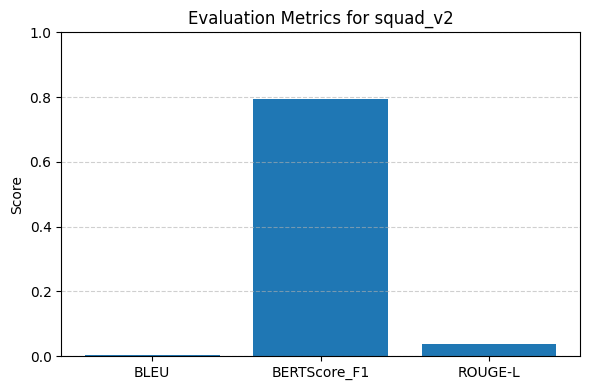

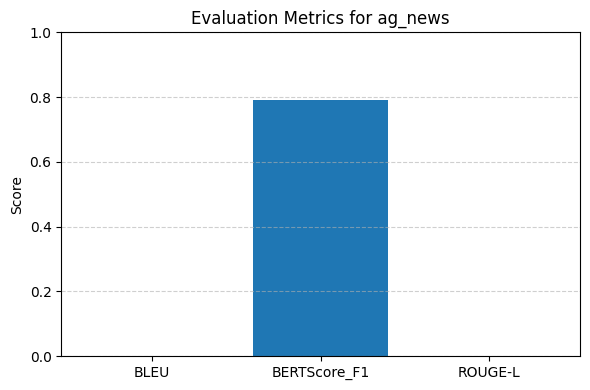

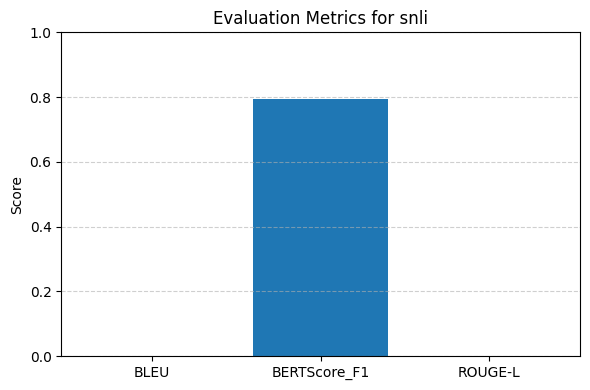

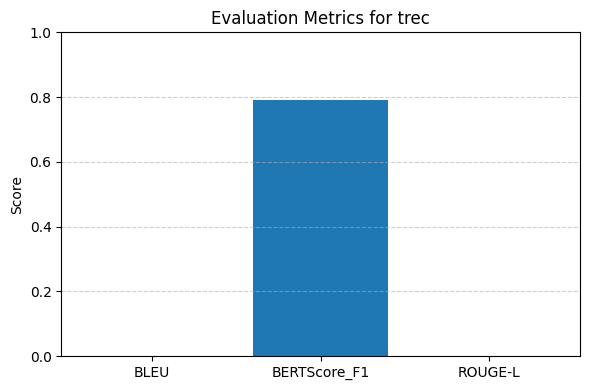

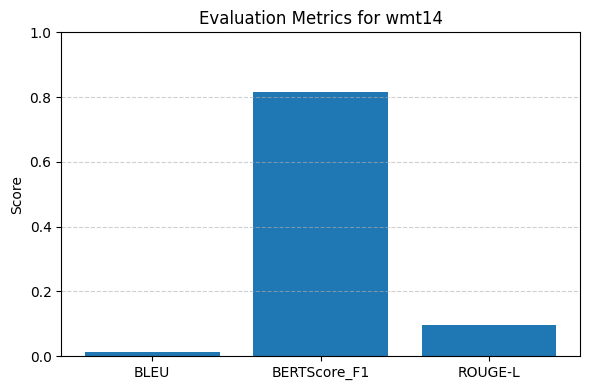

In [17]:
# Inference function
def generate_answer(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=64, do_sample=False)
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Plotting
def plot_metrics(metrics_by_dataset):
    for ds, metrics in metrics_by_dataset.items():
        plt.figure(figsize=(6, 4))
        plt.bar(metrics.keys(), metrics.values())
        plt.title(f"Evaluation Metrics for {ds}")
        plt.ylabel("Score")
        plt.ylim(0, 1)
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.savefig(f"metrics_{ds}.png")
        plt.show()

# Main loop
all_metrics = {}
for name, examples in unified_data.items():
    all_metrics[name] = evaluate(name, examples, False)

plot_metrics(all_metrics)

In [18]:
all_metrics

{'squad_v2': {'BLEU': np.float64(0.0026580094974490843),
  'BERTScore_F1': 0.7936113476753235,
  'ROUGE-L': 0.03820277521473227},
 'ag_news': {'BLEU': np.float64(7.267720807102807e-05),
  'BERTScore_F1': 0.7917486429214478,
  'ROUGE-L': 0.0015762273746301586},
 'snli': {'BLEU': np.float64(4.311376331751697e-05),
  'BERTScore_F1': 0.7951542735099792,
  'ROUGE-L': 0.0015094339474546106},
 'trec': {'BLEU': np.float64(0.0),
  'BERTScore_F1': 0.7898566722869873,
  'ROUGE-L': 0.0017391304181474485},
 'wmt14': {'BLEU': np.float64(0.01257984520473268),
  'BERTScore_F1': 0.8160936236381531,
  'ROUGE-L': 0.09770226539667456}}